In [1]:
import torch
import torchvision
import numpy as np
from torch import nn
import os
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from torch import jit
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x


class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.bn1 = torch.nn.BatchNorm2d(out_c)
        self.relu = torch.nn.ReLU()
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = self.relu(self.bn1(x))
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = encoder_block(3, 32)
        self.enc2 = encoder_block(32, 64)
        self.enc3 = encoder_block(64, 128)
        self.enc4 = encoder_block(128, 256)
        self.enc5 = encoder_block(256, 512)

        self.b = conv_block(512, 1024)

        self.dec1 = decoder_block(1024, 512)
        self.dec2 = decoder_block(512, 256)
        self.dec3 = decoder_block(256, 128)
        self.dec4 = decoder_block(128, 64)
        self.dec5 = decoder_block(64, 32)

        self.segmentator = nn.Conv2d(32, 1, kernel_size=1, padding=0)

    def forward(self, x):
        e1, p1 = self.enc1(x)
        e2, p2 = self.enc2(p1)
        e3, p3 = self.enc3(p2)
        e4, p4 = self.enc4(p3)
        e5, p5 = self.enc5(p4)

        b = self.b(p5)
        d1 = self.dec1(b, e5)
        d2 = self.dec2(d1, e4)
        d3 = self.dec3(d2, e3)
        d4 = self.dec4(d3, e2)
        d5 = self.dec5(d4, e1)
        segmap = self.segmentator(d5)
        return segmap

In [3]:
class CustomDataset():
    def __init__(self, paths_to_images, paths_to_gt, transforms=None):
        self.data = []
        self.labels = []
        self.images_paths = paths_to_images
        self.labels_paths = paths_to_gt
        self.transforms = transforms

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, index):
        img = read_image(self.images_paths[index])
        if len(img.shape) == 2:
            img = img.reshape((1, img.shape[0], img.shape[1]))
        if img.shape[0] == 1:
            img = torch.cat((img, img, img))

        label = read_image(self.labels_paths[index])
        if len(label.shape) == 3 and 1 < label.shape[0] < 5:
            label = label[0, :, :].reshape((1, label.shape[1], label.shape[2]))
        if len(label.shape) == 2:
            label = label.reshape((1, label.shape[0], label.shape[1]))
        if self.transforms is not None:
            img, label = self.transforms(img, label)
        return img, label


def test_transform(image, mask):
    t = transforms.Compose([transforms.Resize((256, 256))])
    image = t(image) / 255
    mask = t(mask) > 127
    return image, mask.float()

def train_transform(image, mask):
    # Resize
    h, w = 256, 256
    p = 100
    resize = transforms.Resize(size=(h, w))
    image = resize(image)
    mask = resize(mask)
    # padding
    pad = transforms.Pad(p, padding_mode='edge')
    image, mask = pad(image), pad(mask)
    # random rotation -20, 20
    deg = 40.0
    r = random.random() - 0.5
    rot = r * deg
    image = transforms.functional.rotate(image, rot)
    mask = transforms.functional.rotate(mask, rot)
    # Random horizontal flipping
    if random.random() > 0.5:
        image = torchvision.transforms.functional.hflip(image)
        mask = torchvision.transforms.functional.hflip(mask)
    perspective = transforms.RandomPerspective()
    params = perspective.get_params(h+p, w+p, 0.3)
    image = transforms.functional.perspective(image, *params)
    mask = transforms.functional.perspective(mask, *params)
    # center crop
    centerCrop = transforms.CenterCrop((h, w))
    image = centerCrop(image)
    mask = centerCrop(mask)
    mask = mask > 127
    return image / 255, mask.float()

In [4]:
from IPython.display import clear_output

SHOW_FREQ = 32
def show_progress(loss_batch, loss_log, train_acc, test_acc=None):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """
    mean_loss = np.mean(loss_batch)
    loss_log = np.append(loss_log, [mean_loss])
    plt.figure(figsize=[12, 4])
    plt.subplot(1, 2, 1)
    plt.plot(loss_log, label="Train loss")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train acc")

    if test_acc is not None:
        plt.plot(test_acc, label="Test acc")
    plt.legend()
    plt.grid()

    clear_output(True)
    print("mean loss over group = %.3f" % (mean_loss,))
    plt.show()

In [5]:
def calc_iou(y, preds):
    # y - zeros and ones (mask)
    # preds - [0, 1]
    binary_preds, binary_y = torch.where(preds > 0.5, 1, 0), torch.where(y == 1, 1, 0)
    intersection = torch.logical_and(binary_preds, binary_y)
    #print(intersection)
    union = torch.logical_or(binary_preds, binary_y)
    #print(union)
    iou = np.array([])
    for i in range(y.shape[0]):
        iou = np.append(iou, (intersection[i].sum() / union[i].sum()).detach().cpu().numpy())
        #print(i+1, iou[-1])
    #print('iou', np.mean(iou))
    return iou

In [6]:
#y = np.zeros((4, 1, 3, 3))
#preds = np.random.random((4, 1, 3, 3))
#img1 = [(0, 0), (0, 1), (1, 0), (1, 1)]
#img2 = [(1, 1), (2, 2), (2, 1), (0, 1), (0, 2)]
#img3 = [(2, 0), (1, 0), (1, 1), (2, 1)]
#img4 = [(2, 2)]
#imgs = [img1, img2, img3, img4]
#for i in range(4):
#    for a, b in imgs[i]:
#        y[i, 0, a, b] = 1
#print(preds)
#print(preds > 0.5)
#print(y)

In [7]:
#calc_iou(torch.from_numpy(y), torch.from_numpy(preds))

In [8]:
from functools import lru_cache
@lru_cache(maxsize=None)
def warm_up(model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    jit.enable_onednn_fusion(True)
    for _, p in enumerate(model.parameters()):
        p.grad = None # better than torch.no_grad()
    return jit.freeze(jit.trace(model, [torch.rand(1, 3, 256, 256).to(device)]))


def get_model():
    model = UNet()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device).float()
    model.eval()
    return model


def predict(model, img_path):
    #model = warm_up(model)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #print(device)
    img = read_image(img_path)
    if len(img.shape) == 2:
        h, w = img.shape
        img = img.reshape((1, h, w))
        img = torch.cat((img, img, img))
    elif img.shape[0] != 3:
        _, h, w = img.shape
        img = img[0, :, :].reshape((1, h, w))
        img = torch.cat((img, img, img))
    else:
        _, h, w = img.shape

    t = transforms.Compose([transforms.Resize((256, 256))])
    img = t(img) / 255
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2])).to(device)
    #print(type(img))
    pred = model(img)
    pred = torch.sigmoid(pred)

    inv_t = transforms.Compose([transforms.Resize((h, w))])
    return inv_t(pred).detach().cpu().numpy()[0, 0]

def train_model(n_epochs=30, model=None):

    '''
    images_folder = train_data_path+'/images'
    gt_folder = train_data_path+'/gt'

    images_paths = []
    labels_paths = []

    for folder in os.listdir(images_folder):
        for filename in os.listdir(images_folder + '/' + folder):
            img_path = images_folder+'/'+folder+'/'+filename
            images_paths.append(img_path)

            gt_path = gt_folder+'/'+folder+'/'+filename
            gt_path = gt_path.split('.')[0] + '.png'
            labels_paths.append(gt_path)
    '''

    img_dir = 'tests/00_test_val_input/'
    train_images_dir = img_dir + 'train/images'
    test_images_dir = img_dir + 'test/images'
    train_gt_dir = img_dir + 'train/gt'
    test_gt_dir = 'tests/00_test_val_gt'
    paths_to_train_images = sorted(['/'.join([train_images_dir, img_folder, img_name]) \
                         for img_folder in os.listdir(train_images_dir) \
                         for img_name in os.listdir(train_images_dir + '/' + img_folder)])
    paths_to_train_gt = sorted(['/'.join([train_gt_dir, gt_folder, gt_name]) \
                         for gt_folder in os.listdir(train_gt_dir) \
                         for gt_name in os.listdir(train_gt_dir + '/' + gt_folder)])


    dataloader = DataLoader(CustomDataset(paths_to_train_images, paths_to_train_gt, transforms=train_transform), batch_size=32,
                            shuffle=True)

    paths_to_test_images = sorted(['/'.join([test_images_dir, img_folder, img_name]) \
                         for img_folder in os.listdir(test_images_dir) \
                         for img_name in os.listdir(test_images_dir + '/' + img_folder)])
    paths_to_test_gt = sorted(['/'.join([test_gt_dir, gt_folder, gt_name]) \
                         for gt_folder in os.listdir(test_gt_dir) \
                         for gt_name in os.listdir(test_gt_dir + '/' + gt_folder)])
    testloader = DataLoader(CustomDataset(paths_to_test_images, paths_to_test_gt, transforms=test_transform), batch_size=32, shuffle=False)

    train_iou, test_iou, loss_log = [], [], []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if model is None:
        model = UNet().to(device).float()
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=0.0001)
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[1, 3, 5, 10, 15, 20, 25], gamma=0.4)
    loss = torch.nn.MSELoss() #BCEWithLogitsLoss()
    for i in range(n_epochs):
        print('Epoch ', i+1, '/', n_epochs)
        # training
        model.train()
        running_iou = np.array([])
        loss_batch = np.array([])
        j = 0
        for batch in tqdm(dataloader):
            x, y = batch
            x, y = x.to(device).contiguous(), y.to(device).contiguous()
            opt.zero_grad()
            preds = model(x)

            # show results
            if j == 0:
                plt.subplots(3, 3)
                for k in range(3):
                    prepare = lambda x: torch.permute(x, (1, 2, 0)).cpu().detach().numpy()
                    plt.subplot(3, 3, 3*k+1)
                    plt.imshow(prepare(x[k]))
                    plt.subplot(3, 3, 3*k+2)
                    plt.imshow(prepare(y[k]))
                    plt.subplot(3, 3, 3*k+3)
                    plt.imshow(prepare(preds[k]))


            running_iou = np.append(running_iou, calc_iou(y, preds))
            l = loss(y, preds)
            loss_batch = np.append(loss_batch, float(l.detach().cpu().numpy()))
            if (j+1) % SHOW_FREQ == 0:
                show_progress(loss_batch, loss_log, train_iou, test_iou)
                loss_log.append(np.mean(loss_batch))
                loss_batch = np.array([])

            l.backward()
            opt.step()
            j += 1
        train_iou.append(np.mean(running_iou))

        # validation
        model.eval()
        running_iou = np.array([])
        for batch in tqdm(testloader):
            x, y = batch
            x = x.to(device).float().contiguous()
            y = y.to(device).float().contiguous()
            preds = model(x)
            running_iou = np.append(running_iou, calc_iou(y, preds))

        test_iou.append(np.mean(running_iou))
        #scheduler.step()
    return model

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
base_dir = '/content/drive/MyDrive/13. Сегментация птиц/'

import zipfile
with zipfile.ZipFile(base_dir + 'tests.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [11]:

img_dir = 'tests/00_test_val_input/'
train_images_dir = img_dir + 'train/images'
test_images_dir = img_dir + 'test/images'
train_gt_dir = img_dir + 'train/gt'
test_gt_dir = 'tests/00_test_val_gt'

In [12]:
paths_to_train_images = sorted(['/'.join([train_images_dir, img_folder, img_name]) \
                         for img_folder in os.listdir(train_images_dir) \
                         for img_name in os.listdir(train_images_dir + '/' + img_folder)])
paths_to_train_gt = sorted(['/'.join([train_gt_dir, gt_folder, gt_name]) \
                         for gt_folder in os.listdir(train_gt_dir) \
                         for gt_name in os.listdir(train_gt_dir + '/' + gt_folder)])
len(paths_to_train_images), len(paths_to_train_gt)

(8382, 8382)

In [13]:
!nvidia-smi

Wed Dec 27 14:16:31 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

mean loss over group = 0.011


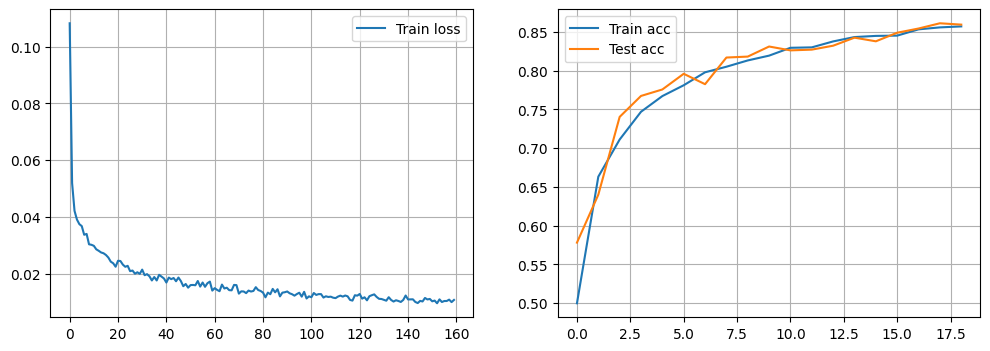

100%|██████████| 44/44 [00:21<00:00,  2.08it/s]


In [14]:
import warnings
warnings.filterwarnings('ignore')

model = train_model(n_epochs=20)

In [15]:
paths_to_test_images = sorted(['/'.join([test_images_dir, img_folder, img_name]) \
                         for img_folder in os.listdir(test_images_dir) \
                         for img_name in os.listdir(test_images_dir + '/' + img_folder)])
paths_to_test_gt = sorted(['/'.join([test_gt_dir, gt_folder, gt_name]) \
                         for gt_folder in os.listdir(test_gt_dir) \
                         for gt_name in os.listdir(test_gt_dir + '/' + gt_folder)])
print('Total number of test objects:', len(paths_to_test_images))
real_test = dict()
predicted_test = dict()
model.eval()
for i in tqdm(range(len(paths_to_test_images))):
    img_name = paths_to_test_images[i]
    gt_name = paths_to_test_gt[i]
    predicted_test[img_name] = predict(model, img_name)


    img = read_image(gt_name)
    if len(img.shape) == 2:
        h, w = img.shape
        img = img.reshape((1, h, w))
        img = torch.cat((img, img, img))
    elif img.shape[0] != 3:
        _, h, w = img.shape
        img = img[0, :, :].reshape((1, h, w))
        img = torch.cat((img, img, img))
    real_test[img_name] = img

Total number of test objects: 1406


100%|██████████| 1406/1406 [00:28<00:00, 48.71it/s]


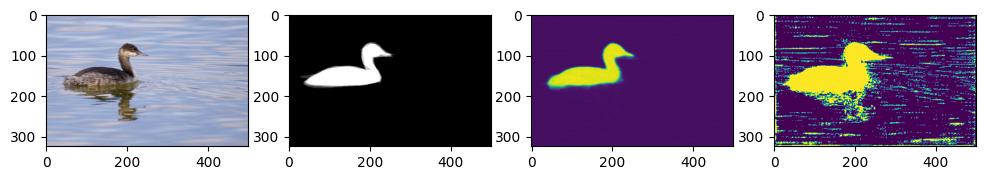

In [30]:
random_idx = random.choice(np.arange(len(paths_to_test_images)))
random_name = paths_to_test_images[random_idx]
random_pred = predicted_test[random_name]
random_gt = real_test[random_name]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 8))

ax1.imshow(torch.permute(read_image(random_name), (1, 2, 0)))
ax2.imshow(torch.permute(random_gt, (1, 2, 0)))
ax3.imshow(random_pred)
ax4.imshow(random_pred>0.5)

In [31]:
def save_model(net, path, descr=''):
    PATH = path + descr
    torch.save({'model_state_dict': net.state_dict()}, PATH)


def load_model(net, path, device, descr=''):
    PATH = path + descr
    net.load_state_dict(torch.load(PATH, map_location=torch.device(device))['model_state_dict'])
    return net

In [32]:
save_model(model, base_dir + 'u_net_20_epochs_iou_85.ckpt')

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet().to(device).float()
net = load_model(net, base_dir + 'u_net_20_epochs_iou_85.ckpt', device)

In [35]:
def test_model(net, testloader):
    net.eval()
    all_ious = np.array([])
    for batch in tqdm(testloader):
        x, y = batch
        x = x.to(device).contiguous()
        y = y.to(device).contiguous()
        preds = net(x)
        metric = calc_iou(y, preds)
        all_ious = np.append(all_ious, metric)
    iou = np.mean(all_ious)
    return iou

testloader = DataLoader(CustomDataset(paths_to_test_images, paths_to_test_gt, transforms=test_transform), batch_size=32, shuffle=False)

iou = test_model(net, testloader)

100%|██████████| 44/44 [00:21<00:00,  2.01it/s]


In [36]:
print('IoU on test dataset is', iou)

IoU on test dataset is 0.85403103653837
